<a href="https://colab.research.google.com/github/akortheanchor/textbook/blob/main/QRC_CreditRiskModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit pandas scikit-learn


In [5]:
!pip install qiskit --upgrade
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.9 MB/s eta 0:00:00


In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, recall_score
import qiskit
from qiskit import QuantumCircuit
# Import AerSimulator from qiskit_aer
from qiskit_aer import AerSimulator  # Import AerSimulator
from imblearn.over_sampling import SMOTE # Import SMOTE

# Replace 'execute' with 'AerSimulator().run'
# from qiskit import execute

# Load the dataset with flexible parsing
try:
    file_path = '/content/german.data-numeric'
    data = pd.read_csv(file_path, sep=' ', header=None, error_bad_lines=False, engine='python')
    print("Dataset loaded successfully.")
except Exception as e:
    print("Error loading dataset:", e)

# Inspect the first few rows
print(data.head())

# Handle missing or irregular rows
# Fill or drop rows with inconsistent data
data = data.dropna()  # Drop rows with missing values
data.columns = [f'Feature_{i}' for i in range(1, data.shape[1])] + ['Target']

# Display final processed dataset shape
print("Processed dataset shape:", data.shape)

# Data Preprocessing
X = data.drop('Target', axis=1)
y = data['Target'].apply(lambda x: 1 if x == 2 else 0)  # Map target: 1 (Good), 0 (Bad)

# Identify categorical features (columns with string values)
categorical_features = X.select_dtypes(include=['object']).columns

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Create OneHotEncoder
encoded_features = encoder.fit_transform(X[categorical_features]) # Fit and transform
encoded_df = pd.DataFrame(encoded_features) # Create DataFrame from encoded features

# Get feature names from encoder
feature_names = encoder.get_feature_names_out(categorical_features)

# Assign string column names to the encoded DataFrame
encoded_df.columns = feature_names

X = X.drop(categorical_features, axis=1) # Drop original categorical features
X = pd.concat([X, encoded_df], axis=1) # Concatenate encoded features

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Apply StandardScaler to the updated X

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)


# Quantum Reservoir Simulation
def quantum_reservoir(data, n_qubits=4):
    # Initialize AerSimulator with 'statevector' method
    simulator = AerSimulator(method='statevector')
    reservoir_outputs = []

    for sample in data:
        qc = QuantumCircuit(n_qubits)

        # Amplitude Encoding
        norm = np.linalg.norm(sample)
        encoded_sample = sample / norm if norm != 0 else sample
        for i, value in enumerate(encoded_sample[:n_qubits]):
            qc.initialize([np.sqrt(1 - value**2), value], i)

        # Random Quantum Circuit (Reservoir)
        for i in range(n_qubits):
            qc.h(i)
        qc.barrier()
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)
        qc.barrier()

        # Measure the statevector
        # Use simulator.run() instead of execute()
        # Add save_statevector instruction to the circuit
        qc.save_statevector() # Save the statevector
        result = simulator.run(qc).result()
        statevector = result.get_statevector() # Get the statevector

        # Correct way to get the real part of the first n_qubits elements:
        reservoir_outputs.append(np.real(statevector.data[:2**n_qubits]))

    return np.array(reservoir_outputs)

# Apply Quantum Reservoir to Train and Test Data
X_train_reservoir = quantum_reservoir(X_train)
X_test_reservoir = quantum_reservoir(X_test)

# Train Logistic Regression Model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_reservoir, y_train)

# Adjust the decision threshold for recall
y_prob = model.predict_proba(X_test_reservoir)[:, 1]
threshold = 0.4  # Lower threshold to prioritize recall
y_pred = (y_prob >= threshold).astype(int)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Recall: {recall}")
print(classification_report(y_test, y_pred))

Error loading dataset: read_csv() got an unexpected keyword argument 'error_bad_lines'
  Feature_1  Feature_2 Feature_3 Feature_4  Feature_5 Feature_6 Feature_7  \
0       A11          6       A34       A43       1169       A65       A75   
1       A12         48       A32       A43       5951       A61       A73   
2       A14         12       A34       A46       2096       A61       A74   
3       A11         42       A32       A42       7882       A61       A74   
4       A11         24       A33       A40       4870       A61       A73   

   Feature_8 Feature_9 Feature_10  ...  Feature_12 Feature_13  Feature_14  \
0          4       A93       A101  ...        A121         67        A143   
1          2       A92       A101  ...        A121         22        A143   
2          2       A93       A101  ...        A121         49        A143   
3          2       A93       A103  ...        A122         45        A143   
4          3       A93       A101  ...        A124         53    

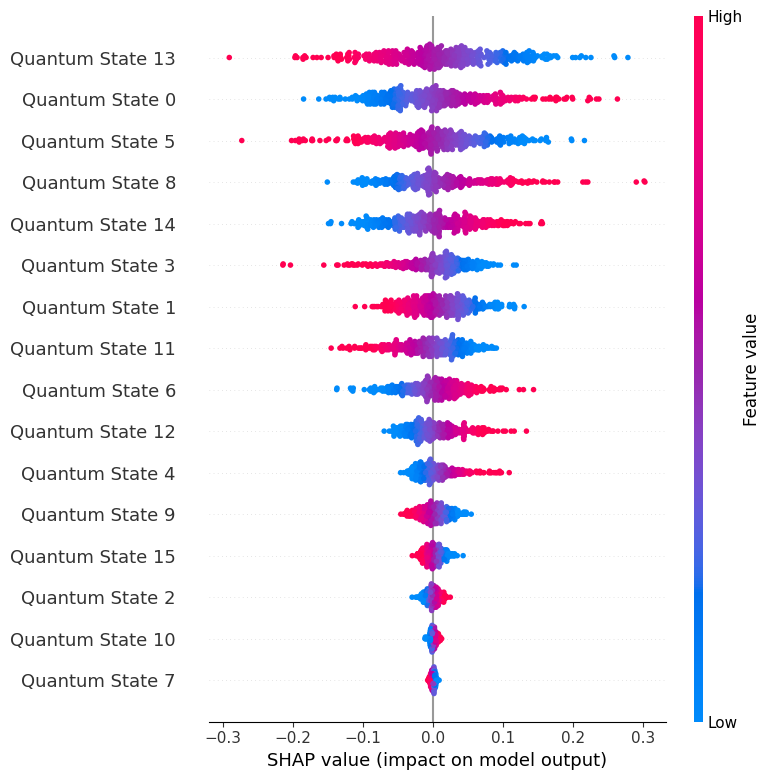

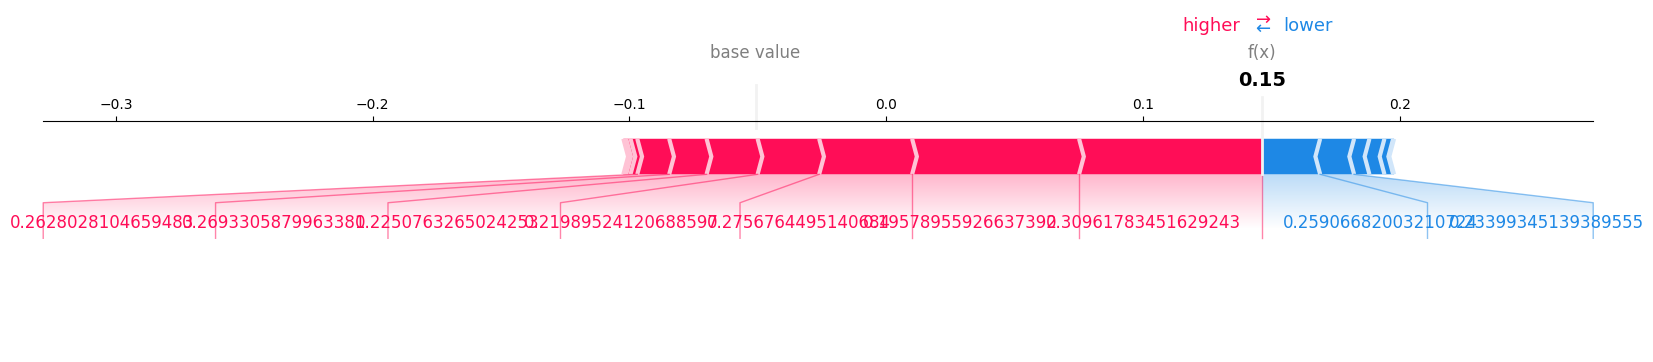

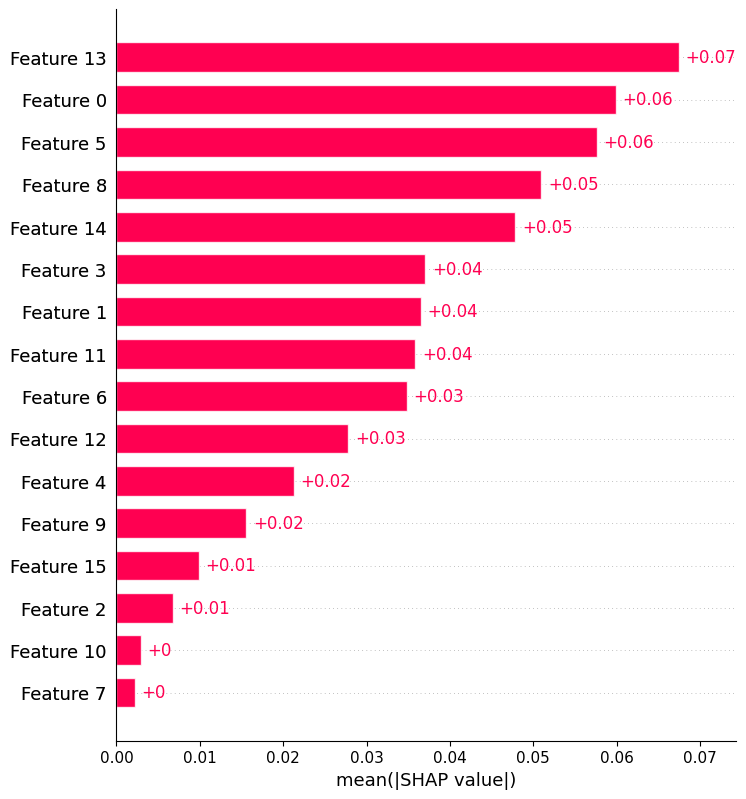

In [32]:
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load preprocessed reservoir features and target labels
# Assuming X_train_reservoir, X_test_reservoir, y_train, y_test are already computed
# Example: X_train_reservoir = quantum_reservoir(X_train)

# Train the logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_reservoir, y_train)

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train_reservoir)

# Generate SHAP values for the test set
shap_values = explainer(X_test_reservoir)

# Get SHAP values for the positive class (class 1)
# Access the values attribute of the Explanation object and select class 1
shap_values_class1 = shap_values.values[:, :, 1] if shap_values.values.ndim == 3 else shap_values.values
# ^ This line now checks the dimensionality and adapts accordingly

# Summary Plot for Overall Feature Importance
shap.summary_plot(shap_values_class1, X_test_reservoir, feature_names=["Quantum State " + str(i) for i in range(X_test_reservoir.shape[1])])

# Force Plot for Individual Prediction
index = 0  # Change index to explore other samples
shap.force_plot(explainer.expected_value, shap_values_class1[index], X_test_reservoir[index, :], matplotlib=True)
# ^ Updated to access the expected value for the class and the correct slice of shap_values

# Bar Plot for Feature Importance
shap.plots.bar(shap_values, max_display=X_test_reservoir.shape[1])
# ^ Updated to use shap_values for class 1

Model: Random Forest
Accuracy: 0.6738095238095239
Recall: 0.6683168316831684
ROC AUC: 0.7450608592969388
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       218
           1       0.66      0.67      0.66       202

    accuracy                           0.67       420
   macro avg       0.67      0.67      0.67       420
weighted avg       0.67      0.67      0.67       420



Model: Gradient Boosting
Accuracy: 0.6619047619047619
Recall: 0.7029702970297029
ROC AUC: 0.7181283495322008
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       218
           1       0.63      0.70      0.67       202

    accuracy                           0.66       420
   macro avg       0.66      0.66      0.66       420
weighted avg       0.67      0.66      0.66       420





 99%|===================| 835/840 [00:19<00:00]       

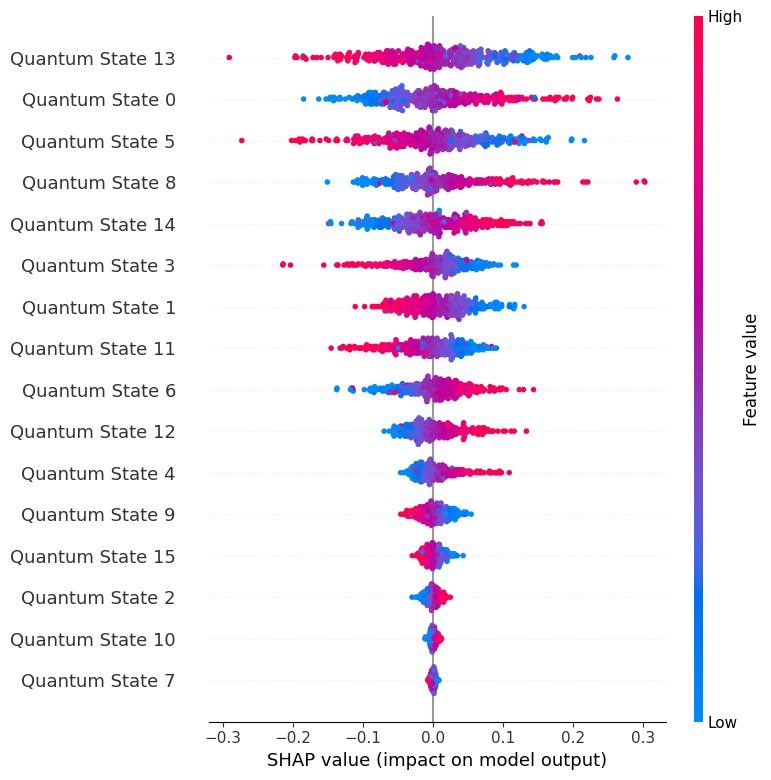

In [36]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import qiskit
from qiskit import QuantumCircuit
# Import AerSimulator from qiskit_aer
from qiskit_aer import AerSimulator  # Import AerSimulator
from imblearn.over_sampling import SMOTE # Import SMOTE
import shap
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/german.data'
data = pd.read_csv(file_path, sep=' ', header=None)

# Assign column names (based on dataset documentation)
column_names = [
    'Status_of_existing_checking_account', 'Duration_in_month', 'Credit_history', 'Purpose',
    'Credit_amount', 'Savings_account', 'Present_employment_since', 'Installment_rate',
    'Personal_status_and_sex', 'Other_debtors', 'Present_residence_since', 'Property',
    'Age_in_years', 'Other_installment_plans', 'Housing', 'Number_of_existing_credits',
    'Job', 'Number_of_people_liable', 'Telephone', 'Foreign_worker', 'Target'
]
data.columns = column_names

# Separate features and target
X = data.drop('Target', axis=1)
y = data['Target']

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Convert categorical columns using one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Add interaction terms using PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_encoded)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interactions)

# Map target values to binary classes
y = y.apply(lambda x: 1 if x == 2 else 0)  # Map target: 1 (Good), 0 (Bad)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Quantum Reservoir Simulation
def quantum_reservoir(data, n_qubits=4):
    simulator = AerSimulator()
    reservoir_outputs = []

    for sample in data:
        qc = QuantumCircuit(n_qubits)

        # Amplitude Encoding
        norm = np.linalg.norm(sample)
        encoded_sample = sample / norm if norm != 0 else sample
        for i, value in enumerate(encoded_sample[:n_qubits]):
            qc.initialize([np.sqrt(1 - value**2), value], i)

        # Random Quantum Circuit (Reservoir)
        for i in range(n_qubits):
            qc.h(i)
        qc.barrier()
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)
        qc.barrier()

        # Measure the statevector
        # Use simulator.run() instead of execute()
        # Add save_statevector instruction to the circuit
        qc.save_statevector() # Save the statevector
        result = simulator.run(qc).result()
        statevector = result.get_statevector() # Get the statevector

        # Correct way to get the real part of the first n_qubits elements:
        reservoir_outputs.append(np.real(statevector.data[:2**n_qubits]))

    return np.array(reservoir_outputs)

# Apply Quantum Reservoir to Train and Test Data
X_train_reservoir = quantum_reservoir(X_train)
X_test_reservoir = quantum_reservoir(X_test)

# Ensemble Model: Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_reservoir, y_train)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_reservoir, y_train)

# Evaluate Models
models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model}
for name, model in models.items():
    y_pred = model.predict(X_test_reservoir)
    y_prob = model.predict_proba(X_test_reservoir)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(classification_report(y_test, y_pred))
    print("\n")

# SHAP Analysis
best_model = rf_model  # Choose the best-performing model
explainer = shap.Explainer(best_model, X_train_reservoir)
shap_values = explainer(X_test_reservoir)

# SHAP Summary Plot
shap.summary_plot(shap_values_class1, X_test_reservoir, feature_names=["Quantum State " + str(i) for i in range(X_test_reservoir.shape[1])])

In [5]:
!pip install qiskit qiskit-aer scikit-learn imbalanced-learn shap matplotlib xgboost

Dataset loaded successfully.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
Accuracy: 0.6761904761904762
Recall: 0.6435643564356436
ROC AUC: 0.7413252793169225
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       218
           1       0.67      0.64      0.66       202

    accuracy                           0.68       420
   macro avg       0.68      0.67      0.68       420
weighted avg       0.68      0.68      0.68       420



Model: SVM
Accuracy: 0.6571428571428571
Recall: 0.6633663366336634
ROC AUC: 0.7223294577164139
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       218
           1       0.64      0.66      0.65       202

    accuracy                           0.66       420
   macro avg       0.66      0.66      0.66       420
weighted avg       0.66      0.66      0.66       420





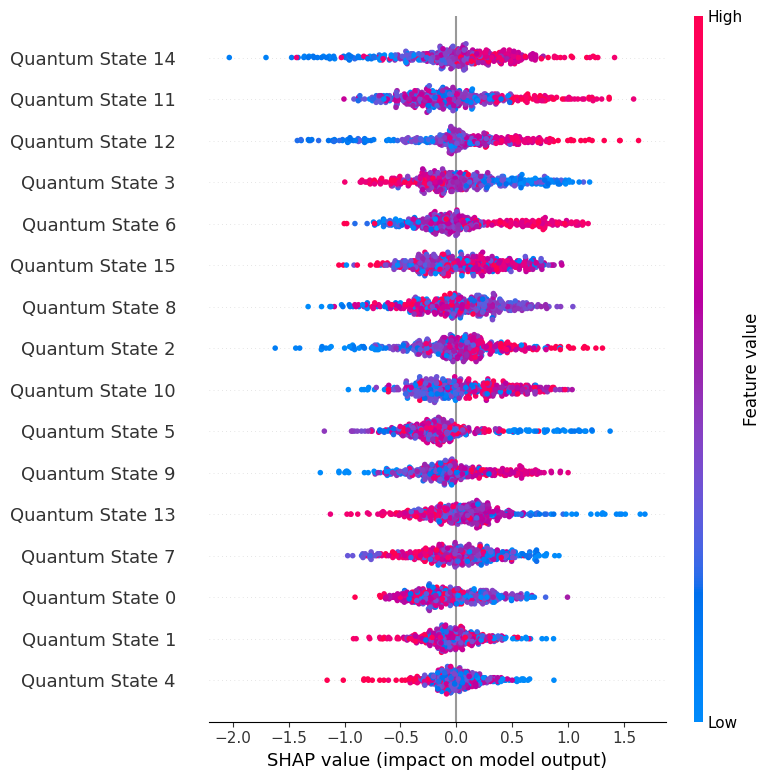

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, recall_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator  # Correct import for AerSimulator
import shap
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/german.data'
try:
    # Load dataset without `error_bad_lines`
    data = pd.read_csv(file_path, sep=' ', header=None, engine='python')
    print("Dataset loaded successfully.")
except Exception as e:
    print("Error loading dataset:", e)
    data = pd.DataFrame()  # Ensure `data` is not undefined if loading fails

# Check if the dataset is empty
if data.empty:
    print("Dataset is empty. Please check the file path or file format.")
else:
    # Assign column names
    column_names = [
        'Status_of_existing_checking_account', 'Duration_in_month', 'Credit_history', 'Purpose',
        'Credit_amount', 'Savings_account', 'Present_employment_since', 'Installment_rate',
        'Personal_status_and_sex', 'Other_debtors', 'Present_residence_since', 'Property',
        'Age_in_years', 'Other_installment_plans', 'Housing', 'Number_of_existing_credits',
        'Job', 'Number_of_people_liable', 'Telephone', 'Foreign_worker', 'Target'
    ]
    data.columns = column_names

    # Separate features and target
    X = data.drop('Target', axis=1)
    y = data['Target']

    # Identify categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Convert categorical columns using one-hot encoding
    X_encoded = pd.get_dummies(X, columns=categorical_columns)

    # Add interaction terms using PolynomialFeatures
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    X_interactions = poly.fit_transform(X_encoded)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_interactions)

    # Map target values to binary classes
    y = y.apply(lambda x: 1 if x == 2 else 0)  # Map target: 1 (Good), 0 (Bad)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Quantum Reservoir Simulation
    def quantum_reservoir(data, n_qubits=4):
        simulator = AerSimulator()
        reservoir_outputs = []

        for sample in data:
            qc = QuantumCircuit(n_qubits)

            # Amplitude Encoding
            norm = np.linalg.norm(sample)
            encoded_sample = sample / norm if norm != 0 else sample
            for i, value in enumerate(encoded_sample[:n_qubits]):
                qc.initialize([np.sqrt(1 - value**2), value], i)

            # Random Quantum Circuit (Reservoir)
            for i in range(n_qubits):
                qc.h(i)
            qc.barrier()
            for i in range(n_qubits - 1):
                qc.cx(i, i + 1)
            qc.barrier()

            # Save and execute statevector simulation
            qc.save_statevector()
            result = simulator.run(qc).result()
            statevector = result.get_statevector()
            reservoir_outputs.append(np.real(statevector.data[:2**n_qubits]))

        return np.array(reservoir_outputs)

    # Apply Quantum Reservoir to Train and Test Data
    X_train_reservoir = quantum_reservoir(X_train)
    X_test_reservoir = quantum_reservoir(X_test)

    # Model 1: XGBoost
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_reservoir, y_train)

    # Model 2: SVM
    svm_model = SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42)
    svm_model.fit(X_train_reservoir, y_train)

    # Evaluate Models
    models = {'XGBoost': xgb_model, 'SVM': svm_model}
    for name, model in models.items():
        y_pred = model.predict(X_test_reservoir)
        y_prob = model.predict_proba(X_test_reservoir)[:, 1] if hasattr(model, "predict_proba") else None
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy}")
        print(f"Recall: {recall}")
        print(f"ROC AUC: {roc_auc}")
        print(classification_report(y_test, y_pred))
        print("\n")

    # SHAP Analysis for XGBoost
    explainer = shap.Explainer(xgb_model, X_train_reservoir)
    shap_values = explainer(X_test_reservoir)

    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_test_reservoir, feature_names=["Quantum State " + str(i) for i in range(X_test_reservoir.shape[1])])


In [2]:
!pip install qiskit

In [4]:
!pip install qiskit qiskit-aer scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 44.7 MB/s eta 0:00:00


Proof of Concept: **QRC Model **

In [8]:
# Import libraries
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, Aer  # Import Aer along with AerSimulator
#from qiskit import QuantumCircuit, Aer, transpile, assemble # commented out this line as this is incorrect
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score

# Load the dataset (upload file manually in Colab)
from google.colab import files
uploaded = files.upload()

import pandas as pd
data_numeric = pd.read_csv("german.data-numeric", delim_whitespace=True, header=None)

# Preprocessing
X = StandardScaler().fit_transform(data_numeric.iloc[:, :-1])
y = LabelBinarizer().fit_transform(data_numeric.iloc[:, -1]).ravel()

# Quantum Encoding
def encode_features_to_quantum_state(features):
    num_qubits = len(features)
    circuit = QuantumCircuit(num_qubits)
    for i, feature in enumerate(features):
        circuit.rx(feature * np.pi, i)
    return circuit

# Quantum Reservoir Simulation
def quantum_reservoir_simulation(circuit):
    num_qubits = circuit.num_qubits
    for i in range(num_qubits - 1):
        circuit.cz(i, i + 1)
    circuit.h(range(num_qubits))
    return circuit

# Measure Quantum State
def measure_quantum_state(circuit, num_qubits):
    circuit.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    # Remove assemble and transpile
    # qobj = assemble(transpile(circuit, backend=backend), shots=1024)
    # Run the circuit directly:
    result = backend.run(circuit, shots=1024).result()
    counts = result.get_counts()
    feature_vector = np.array([counts.get(f"{i:0{num_qubits}b}", 0) for i in range(2**num_qubits)])
    return feature_vector / np.sum(feature_vector)

# QRC Model
def qrc_credit_risk_model(X, y, num_qubits=4):
    quantum_features = []
    for features in X:
        truncated_features = features[:num_qubits]
        circuit = encode_features_to_quantum_state(truncated_features)
        reservoir_circuit = quantum_reservoir_simulation(circuit)
        quantum_features.append(measure_quantum_state(reservoir_circuit, num_qubits))
    quantum_features = np.array(quantum_features)

    X_train, X_test, y_train, y_test = train_test_split(quantum_features, y, test_size=0.3, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"QRC Model Accuracy: {accuracy:.2f}")
    return model

# Execute the QRC model
qrc_model = qrc_credit_risk_model(X, y)


Saving german.data-numeric to german (2).data-numeric


<ipython-input-8-82c7a999763e>:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_numeric = pd.read_csv("german.data-numeric", delim_whitespace=True, header=None)


QRC Model Accuracy: 0.70


In [10]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=e824f47e20751c598a9d1e2418f6c014a41dd4bca276ef5a1ee9f2e49e4295b8
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


Quantum Reservoir Circuit:
      ┌─────────────┐    ┌───┐                                             »
 q_0: ┤ Rx(-3.9413) ├──■─┤ H ├─────────────────────────────────────────────»
      ├─────────────┤  │ └───┘┌───┐                                        »
 q_1: ┤ Rx(-3.8845) ├──■───■──┤ H ├────────────────────────────────────────»
      └┬────────────┤      │  └───┘┌───┐                                   »
 q_2: ─┤ Rx(4.2223) ├──────■────■──┤ H ├───────────────────────────────────»
      ┌┴────────────┤           │  └───┘┌───┐                              »
 q_3: ┤ Rx(-2.3041) ├───────────■────■──┤ H ├──────────────────────────────»
      └┬────────────┤                │  └───┘┌───┐                         »
 q_4: ─┤ Rx(5.7591) ├────────────────■────■──┤ H ├─────────────────────────»
       ├────────────┤                     │  └───┘┌───┐                    »
 q_5: ─┤ Rx(4.2037) ├─────────────────────■────■──┤ H ├────────────────────»
       ├────────────┤                          │ 

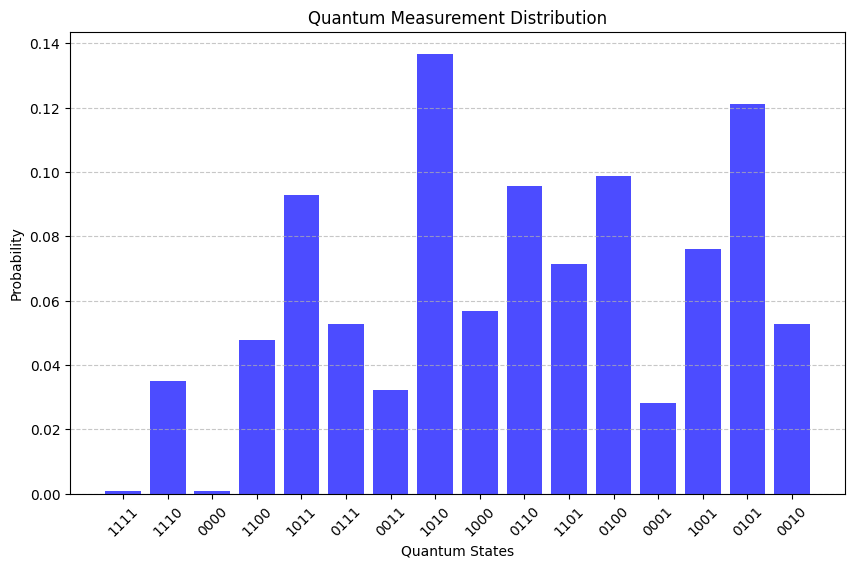

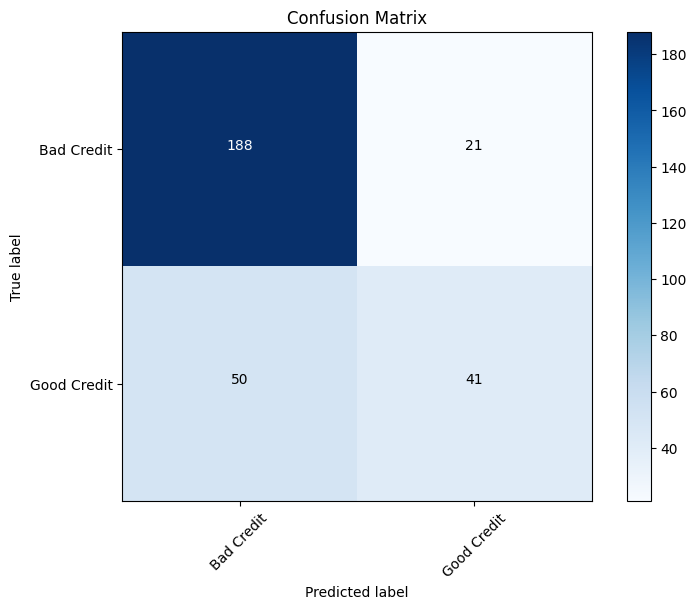

In [15]:
# Import libraries for visualization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 1: Visualize the Quantum Encoding Circuit
def visualize_quantum_circuit(features):
    circuit = encode_features_to_quantum_state(features)
    reservoir_circuit = quantum_reservoir_simulation(circuit)
    print("Quantum Reservoir Circuit:")
    print(reservoir_circuit.draw("text"))  # Use text-based drawer as an alternative

# Step 2: Visualize Quantum State Measurement
def visualize_measurement_distribution(features, num_qubits):
    circuit = encode_features_to_quantum_state(features[:num_qubits])
    reservoir_circuit = quantum_reservoir_simulation(circuit)
    circuit.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(circuit, shots=1024).result()
    counts = result.get_counts()

    # Prepare data for plotting
    states = list(counts.keys())
    frequencies = list(counts.values())
    probabilities = [freq / sum(frequencies) for freq in frequencies]

    # Bar plot for measurement distribution
    plt.figure(figsize=(10, 6))
    plt.bar(states, probabilities, color='blue', alpha=0.7)
    plt.xlabel("Quantum States")
    plt.ylabel("Probability")
    plt.title("Quantum Measurement Distribution")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Step 3: Visualize Model Performance
def visualize_model_performance(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    labels = ["Bad Credit", "Good Credit"]

    # Heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Add text annotations
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Execute Visualizations
# Visualize a sample quantum circuit and measurement
sample_features = X[0]  # Select a sample feature set
visualize_quantum_circuit(sample_features)
visualize_measurement_distribution(sample_features, num_qubits=4)

# Visualize the model's performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
visualize_model_performance(y_test, y_pred)
